In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression  
import torch


In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

In [223]:
M = 10 # Number of Spiking motifs
N = 100 # Number of input neurons
D = 71 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 10 # hz
pg_fr = 10 # hz
background_noise_fr = 10 # hz


np.random.seed(41)

# colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#2c7e9a'])




In [231]:
num_trials = 5

N_array = [50,100,120,150,200]#,500,1000]
M_array = [5,10,20,40,80,160,320]#,640,1280]
D_array = [31,51,71,91,101,121]#,241,481]
T_array = [1000]#,2000,3000,4000,5000]
nrn_fr_array = [20,25,30,40,50,70,90,500]
pg_fr_array = [4,8,16,32,64,100,500]
background_noise_fr_array=[10,50,100,200,400,800]

parameter = pg_fr_array

performance = np.zeros((len(parameter),num_trials))

scan_dict = {
    'N':N_array,
    'M':M_array,
    'D':D_array,
    'T':T_array,
    'nrn_fr':nrn_fr_array,
    'pg_fr':pg_fr_array,
    'background_noise_fr':background_noise_fr_array
}
default_params = {    
    'N':20,
    'M':9,
    'D':31,
    'T':1000,
    'nrn_fr':10,
    'pg_fr':5,
    'background_noise_fr':0
}

params = default_params.copy()



In [232]:
'''
I want to store the performances in a dictionary?? of the same shape as scan_dicts, but with: loss, accuracy, TP and TN
'''

'\nI want to store the performances in a dictionary?? of the same shape as scan_dicts, but with: loss, accuracy, TP and TN\n'

In [233]:
def gen_experiment(params,K=None):
    N,M,D,T,nrn_fr,pg_fr,background_noise_fr = params.values()
    

    '''
    Generate the PG Kernels
    '''
    if K == None:
        K_dense = np.random.randint(0,T-1,(N,D,M))
        K_dense[K_dense < nrn_fr] = 1
        K_dense[K_dense >= nrn_fr] = 0
        K_sparse = np.where(K_dense)
    else:
        K_dense,K_sparse = K

    '''
    Generate the PG occurrences
    '''

    condition=True
    while condition:
        B_dense = np.random.randint(0,T-1,(M,T))
        B_dense[B_dense < pg_fr] = 1
        B_dense[B_dense != 1] = 0
        B_sparse = np.where(B_dense)
        if len(np.unique(B_sparse[0])) == M:
            condition = False

    '''
    Convolve the PG kernels with the PG firing times
    '''

    # now to make the full raster plot keeping the labels in-tact
    # dense A: the layered binary images of all neuron spikes by PG ( N x T x M)
    A_dense = np.zeros((N,T+D,M+1))
    A_dense[...,-1] = np.random.randint(0,T-1,(N,T+D))
    A_dense[...,-1][A_dense[...,-1]<background_noise_fr] =1
    A_dense[...,-1][A_dense[...,-1]!=1] = 0
    for i in range(len(B_sparse[0])):
        t = B_sparse[1][i]
        b = B_sparse[0][i]
        A_dense[:, t:t+D, b] += K_dense[...,b]

    A_dense.shape
    # A_dense = A_dense[:,:1000,:]
    A_sparse = np.where(A_dense)
    A_dense = np.sum(A_dense,axis=2)
    A_dense[A_dense>1] = 1
    A_dense.shape
    
    return K_dense, K_sparse, B_dense, B_sparse, A_dense, A_sparse


In [234]:
np.random.seed(41)

performance = {}

# scan_dict = {
#     'N':[20],
# }
threshold = 0.3

gt_stats = []
for key_idc, key in enumerate(scan_dict):
    
    performance[key] = np.zeros((len(scan_dict[key]), num_trials, 4))
    for val_idc, val in enumerate(scan_dict[key]):
        
        params = default_params.copy()
        params[key]=val
        N,M,D,T,nrn_fr,pg_fr,background_noise_fr = params.values()

        
        for trial in tqdm(range(num_trials)):

            K_dense, K_sparse, B_dense, B_sparse, A_dense, A_sparse = gen_experiment(params)

            '''
            Prepare the training dataset for logistic regression
            '''

            x_train = [np.zeros((T,N,D)) for k in range(M)]
            y_train = [np.zeros((T)) for k in range(M)]
            
            for j in range(M):
                for i in range(T):
                    x_train[j][i,...] = A_dense[:,i:D+i]
                y_train[j] = B_dense[j,:]
                x_train[j]=x_train[j].reshape(x_train[j].shape[0],x_train[j].shape[1]*x_train[j].shape[2])
            
            '''
            Prepare the test dataset for lr
            '''

            x_test = [np.zeros((T,N,D)) for k in range(M)]
            y_test = [np.zeros((T)) for k in range(M)]
            
            K_dense, K_sparse, B_dense, B_sparse, A_dense, A_sparse = gen_experiment(params,K=(K_dense,K_sparse))
            
            for j in range(M):
                for i in range(T):
                    x_test[j][i,...] = A_dense[:,i:D+i]
                y_test[j] = B_dense[j,:]
                x_test[j]=x_test[j].reshape(x_test[j].shape[0],x_test[j].shape[1]*x_test[j].shape[2])
            
            w= []
            y_pred = []

            '''
            Supervised Learning
            '''
            y_pred_miles = np.zeros_like(B_dense,dtype='float')
            for j in range(M):
                x = torch.from_numpy(x_train[j].astype(np.float32))
                y = torch.from_numpy(y_train[j].astype(np.float32))


                classifier= LogisticRegression(max_iter=500000, random_state=0)  

                classifier.fit(x, y.ravel()) 
                y_pred.append(classifier.predict(x_test[j]))
                
          
                
                win = classifier.coef_.reshape(N,D)
                win[win>threshold]=1
                win[win<=threshold]=0
                
                for t in range(T):
                    if np.sum(win) !=0:
                        y_pred_miles[j,t] = np.sum(win * A_dense[:,t:t+D])/np.sum(win)
                        
#                     print(np.sum(win * A_dense[:,t:t+D])/np.sum(win))
#                     print(y_pred_miles[j,t])
                
               
                w.append(classifier.coef_)
                w[-1] = w[-1].T
                w[-1] = w[-1].reshape(N,D)     
                
            y_pred_miles[y_pred_miles <1] = 0
            w = np.array(w)
            y_pred = np.array(y_pred)
            
            loss = 0
            accuracy = (B_dense.size- np.sum(np.abs(B_dense - y_pred_miles))) /B_dense.size
            TP = np.mean(y_pred_miles[B_dense==1])
            TN = 1 - np.mean(y_pred_miles[B_dense==0])
            
            
            performance[key][val_idc][trial] = [loss,accuracy,TP,TN]

            
    #         performance[idc,trial] = ((np.sum(B_dense) - np.sum(np.abs(B_dense - y_pred))) /np.sum(B_dense))


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


In [238]:
performance['M'].shape

(7, 5, 4)

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(len(means), 3, figsize=(12, 50), sharey=True)
cols = dfs[0].columns
for i in range(len(means)):
    key = dfs[i].columns[0]
    names = dfs[i][key].unique()
    axs[i,0].bar(names.astype('str'), means[i][:,0])
    axs[i,1].bar(names.astype('str'), means[i][:,1])
    axs[i,2].bar(names.astype('str'), means[i][:,2])
    axs[i,0].set_ylabel(key)
    
axs[0,0].set_title(cols[1])
axs[0,1].set_title(cols[2])
axs[0,2].set_title(cols[3])

fig.tight_layout()
plt.show()

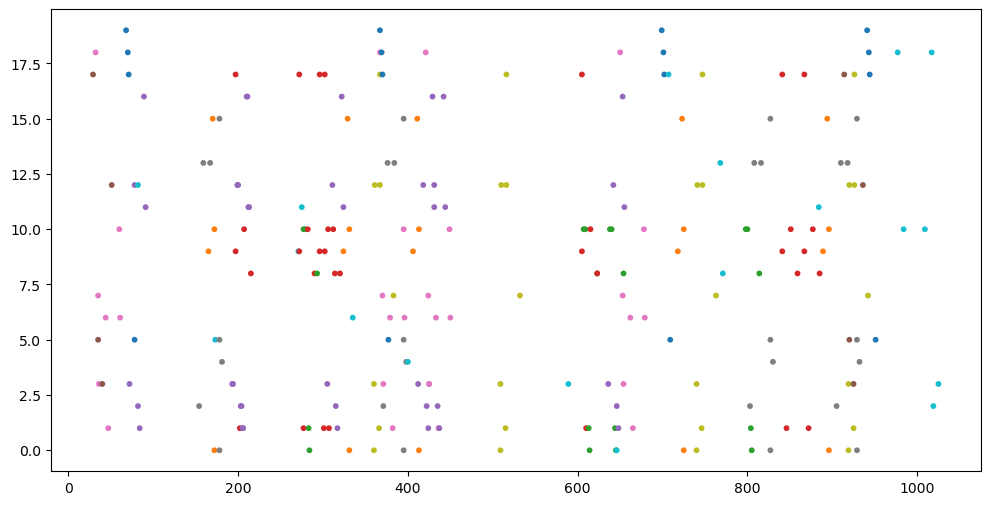

In [186]:
%matplotlib inline
plt.figure(figsize=(12,6))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],s=10)
plt.show()

In [187]:
y_pred_miles

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

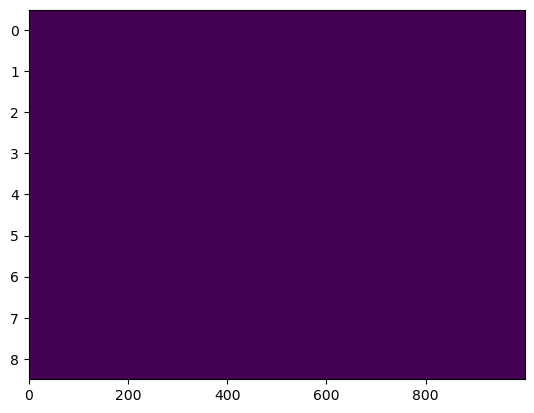

In [192]:
plt.figure()
plt.imshow(B_dense-y_pred_miles,aspect='auto')

In [188]:
np.where(y_pred_miles)

(array([0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8],
       dtype=int64),
 array([ 48, 347, 679, 921, 149, 308, 390, 702, 873, 275, 605, 636, 796,
        188, 263, 287, 293, 596, 832, 858,  70, 191, 192, 303, 410, 423,
        634,  25, 910,  31, 366, 420, 649, 153, 370, 802, 904, 355, 504,
        735, 914], dtype=int64))

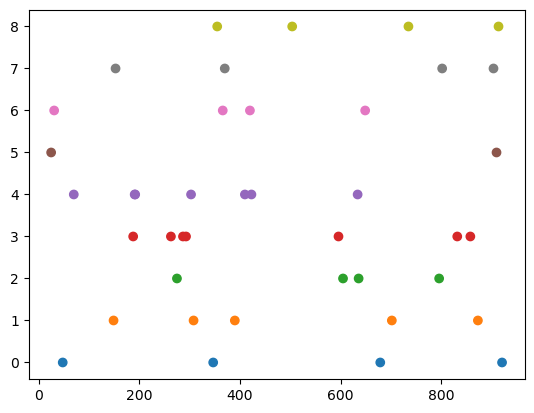

In [189]:
y_pred_miles[y_pred_miles <1] = 0
plt.figure()
plt.scatter(np.where(y_pred_miles)[1],np.where(y_pred_miles)[0],c=colors[np.where(y_pred_miles)[0]])
plt.show()

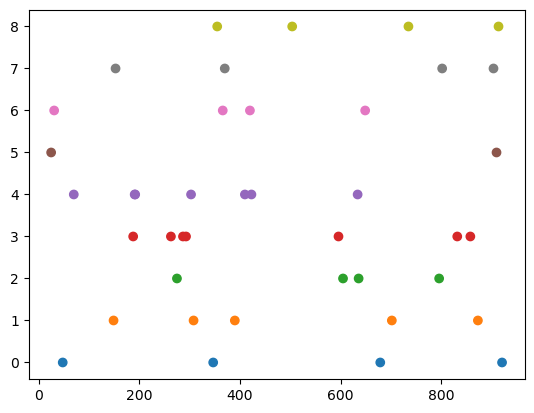

In [190]:
plt.figure()
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]])
plt.show()

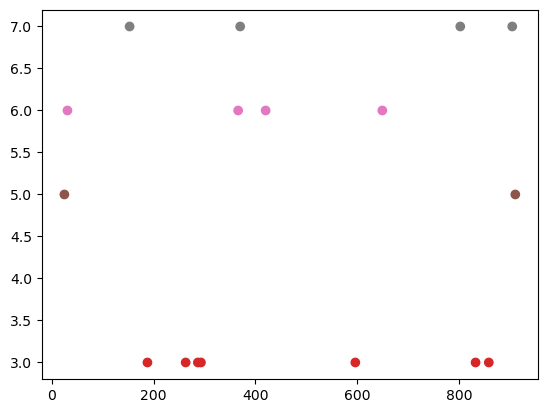

In [11]:
plt.figure()
plt.scatter(np.where(y_pred)[1],np.where(y_pred)[0],c=colors[np.where(y_pred)[0]])
plt.show()

In [12]:
w.shape, K_dense.shape

((9, 20, 31), (20, 31, 9))

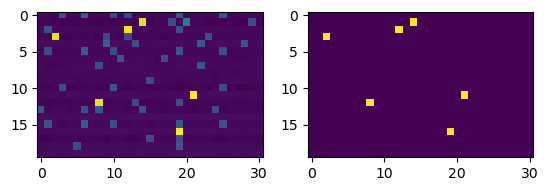

In [48]:
%matplotlib inline
fig,ax = plt.subplot_mosaic('AB')
i=4
ax['A'].imshow(w[i,:,:])
ax['B'].imshow(K_dense[:,:,i])

In [27]:
w[:,0,0].shape[0]

9

In [203]:
from scipy.stats import norm
from scipy.stats import percentileofscore

In [220]:
w[j,:,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0

In [210]:
for i in range(w[:,0,0].shape[0]):
    target = np.min(w[i,:,:][np.where(K_dense[:,:,i])])
    mean_ = np.mean(w[i,:,:])
    std = np.std(w[i,:,:])
    quantile = norm.ppf(0.999999, loc=mean_, scale=std)
    outlier = w[i,:,:].copy()
    outlier[np.where(K_dense[:,:,i])] = 0
    outlier = np.max(outlier)
    print(target,outlier)
    print(percentileofscore(w[i,:,:].ravel(),target))
#     print(percentileofscore(w[i,:,:].ravel(),outlier))
#     print(target,outlier, mean_, std, quantile)

0.0 0.0
50.08064516129032
0.0 0.0
50.08064516129032
0.0 0.0
50.08064516129032
0.0 0.0
50.08064516129032
0.0 0.0
50.08064516129032
0.0 0.0
50.08064516129032
0.0 0.0
50.08064516129032
0.0 0.0
50.08064516129032
0.0 0.0
50.08064516129032


C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\scipy\stats\_distn_infrast

In [190]:
w[:,2,:].shape

(9, 31)

In [209]:
%matplotlib qt
fig = plt.figure(figsize=(8, 3))
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(111, projection='3d')
x,y = np.arange(0,w[2,:,:].shape[0]),np.arange(0,w[2,:,:].shape[1])
_xx, _yy = np.meshgrid(x, y)
x, y = _xx.ravel(), _yy.ravel()
top = w[2,:,:].ravel()
bottom = np.zeros_like(top)
depth = width = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)

In [180]:
performance

{'N': array([[[       nan, 0.5952381 , 0.59523809, 1.        ]],
 
        [[       nan, 0.70731707, 0.70731705, 1.        ]],
 
        [[       nan, 0.58695652, 0.5869565 , 1.        ]],
 
        [[       nan, 0.76086957, 0.76086956, 1.        ]],
 
        [[       nan, 0.6557377 , 0.6557377 , 1.        ]]]),
 'M': array([[[       nan, 0.2       , 0.2       , 1.        ]],
 
        [[       nan, 0.45      , 0.44999999, 1.        ]],
 
        [[       nan, 0.05952381, 0.05952381, 1.        ]],
 
        [[       nan, 0.        , 0.        , 1.        ]],
 
        [[       nan, 0.        , 0.        , 1.        ]],
 
        [[       nan, 0.        , 0.        , 1.        ]],
 
        [[       nan, 0.        , 0.        , 1.        ]]]),
 'D': array([[[       nan, 0.52173913, 0.52173913, 1.        ]],
 
        [[       nan, 0.28888889, 0.2888889 , 1.        ]],
 
        [[       nan, 0.23333333, 0.23333333, 1.        ]],
 
        [[       nan, 0.13636364, 0.13636364, 1.       

In [68]:
performance

{'N': array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [nan,  1.,  1.,  1.]])}

In [54]:
scan_dicts['Ns']

[100, 120, 150, 200, 500, 1000]

In [58]:
performance

{'N': array([[nan,  1.,  1.,  0.]])}

In [47]:
len(scan_dict[key])

6

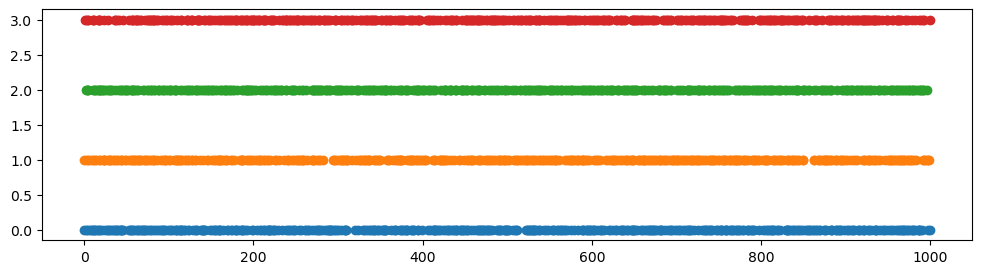

In [7]:
plt.figure(figsize=(12,3))
[plt.scatter(B_sparse[1][B_sparse[0]==i],B_sparse[0][B_sparse[0]==i],c=colors[i]) for i in range(4)]
plt.show()

In [8]:
np.array([parameter for k in range(performance.shape[1])]).T.shape, performance.shape

((7, 1), (7, 1))

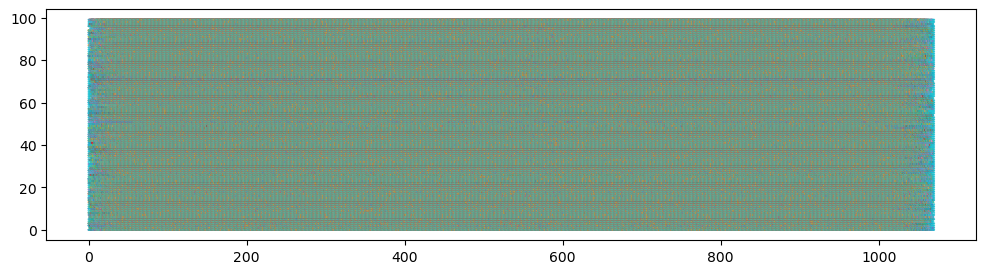

In [9]:
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=1,marker='.')
plt.show()

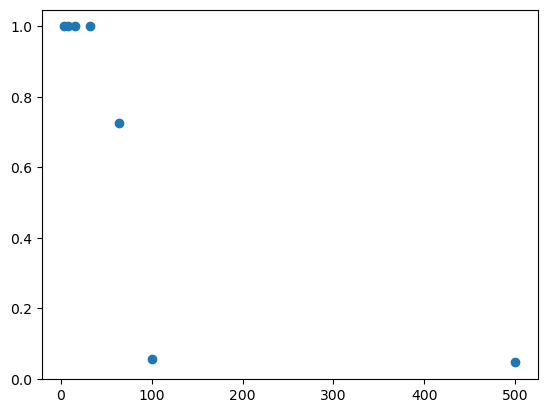

In [10]:
plt.figure()
plt.scatter(np.array([parameter for k in range(performance.shape[1])]),performance)

<BarContainer object of 6 artists>

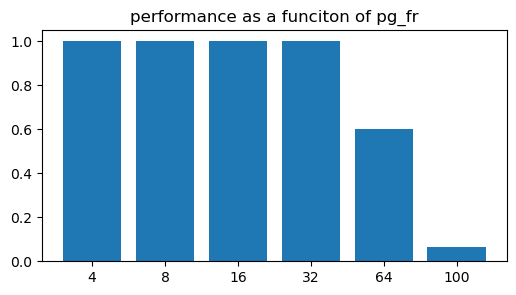

In [36]:
plt.figure(figsize=(6,3))
plt.title('performance as a funciton of pg_fr')

plt.bar(np.array(parameter).astype('str'),performance.squeeze())

In [180]:
performance

[17.0, 20.0, 13.0, 12.0, 18.0, 13.0, 15.0, 10.0, 18.0, 17.0]

okay... sklearn's logistic regression funtction is blazing fast, and performs better than pytorch's ... What am I doing wrong lol


# Performance

In [137]:
(np.sum(B_dense) - np.sum(np.abs(B_dense - y_pred)))/np.sum(B_dense)

0.8823529411764706

In [138]:
B_dense.shape

(4, 1000)